# Smart Retail: Customer Purchase Prediction

This notebook implements an end-to-end demo recommendation/prediction pipeline:
1. Generate **synthetic** customers, products, and transactions  
2. Perform quick EDA  
3. Feature engineering (RFM + spending behavior)  
4. Customer segmentation using **K-Means**  
5. Next purchase category prediction using **Random Forest**  
6. Output top-k category recommendations with probabilities (CSV)

(Aligned with the project report.) fileciteturn0file0


In [3]:
!pip install numpy pandas matplotlib scikit-learn

# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# ML
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

# Reproducibility
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 27.8 MB/s  0:00:00m0:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 38.2 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 51.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 50.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 51.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 43.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 50.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 52.8 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14/14 [matplotlib]4 [matplotlib]n]


## 1) Generate synthetic retail data

In [4]:
from datetime import datetime, timedelta

# Parameters (adjust to scale up/down)
N_CUSTOMERS = 500
N_PRODUCTS  = 200
N_TXNS      = 8000
N_CATEGORIES = 8

categories = ["fashion","electronics","grocery","home","beauty","sports","toys","books"][:N_CATEGORIES]

# Customers
customers = pd.DataFrame({
    "customer_id": np.arange(1, N_CUSTOMERS+1),
    "age": rng.integers(18, 70, size=N_CUSTOMERS),
    "gender": rng.choice(["F","M","Other"], size=N_CUSTOMERS, p=[0.48,0.48,0.04]),
    "income_band": rng.choice(["low","mid","high"], size=N_CUSTOMERS, p=[0.35,0.50,0.15]),
    "region": rng.choice(["west","midwest","south","northeast"], size=N_CUSTOMERS, p=[0.25,0.20,0.30,0.25]),
})

# Products
products = pd.DataFrame({
    "product_id": np.arange(1, N_PRODUCTS+1),
    "category": rng.choice(categories, size=N_PRODUCTS, p=np.ones(len(categories))/len(categories)),
})

# Category price ranges (roughly)
cat_price = {
    "fashion": (15, 120),
    "electronics": (60, 900),
    "grocery": (2, 50),
    "home": (10, 300),
    "beauty": (5, 80),
    "sports": (10, 250),
    "toys": (5, 120),
    "books": (5, 60),
}
def sample_price(cat, size=1):
    low, high = cat_price.get(cat, (5, 100))
    # right-skewed with lognormal then clipped
    x = rng.lognormal(mean=np.log((low+high)/2), sigma=0.6, size=size)
    return np.clip(x, low, high)

# Create transaction timestamps with light seasonality
end_date = datetime(2025, 12, 31)
start_date = end_date - timedelta(days=365)

def sample_date(size=1):
    # day-of-year weighting (higher in Nov-Dec)
    days = np.arange(365)
    weights = np.ones(365)
    weights[300:365] *= 1.6  # holiday bump
    weights[0:31] *= 1.1     # January bump
    weights = weights / weights.sum()
    chosen = rng.choice(days, size=size, p=weights)
    return [start_date + timedelta(days=int(d), hours=int(rng.integers(0,24))) for d in chosen]

# Base category preference per customer (simple: depends on income_band + randomness)
pref = {}
for cid, inc in zip(customers.customer_id, customers.income_band):
    base = np.ones(len(categories))
    if inc == "low":
        boost = {"grocery": 1.6, "books":1.2, "beauty":1.1}
    elif inc == "mid":
        boost = {"fashion":1.3, "home":1.2, "grocery":1.2}
    else:
        boost = {"electronics":1.5, "fashion":1.2, "home":1.2}
    for i, c in enumerate(categories):
        base[i] *= boost.get(c, 1.0)
    # add noise
    base = base * rng.uniform(0.8, 1.2, size=len(categories))
    pref[cid] = base / base.sum()

# Transactions
tx_customer = rng.integers(1, N_CUSTOMERS+1, size=N_TXNS)
tx_dates = sample_date(N_TXNS)

tx_rows = []
for i in range(N_TXNS):
    cid = int(tx_customer[i])
    cat = rng.choice(categories, p=pref[cid])
    # pick a product from that category
    prod_id = int(products.loc[products.category == cat, "product_id"].sample(
        n=1, random_state=int(rng.integers(0, 1_000_000_000))
    ).iloc[0])
    price = float(sample_price(cat, 1)[0])
    qty = int(rng.integers(1, 4))
    tx_rows.append((i+1, cid, prod_id, cat, tx_dates[i], qty, price))

transactions = pd.DataFrame(tx_rows, columns=["txn_id","customer_id","product_id","category","txn_time","qty","unit_price"])
transactions["amount"] = transactions["qty"] * transactions["unit_price"]

customers.head(), products.head(), transactions.head()


(   customer_id  age gender income_band region
 0            1   22      M         low   west
 1            2   58      M         low   west
 2            3   52      F         low   west
 3            4   40      F         mid  south
 4            5   40      F         mid   west,
    product_id     category
 0           1       sports
 1           2  electronics
 2           3        books
 3           4         toys
 4           5      grocery,
    txn_id  customer_id  product_id     category            txn_time  qty  \
 0       1          455         165  electronics 2025-01-01 13:00:00    1   
 1       2          174         146  electronics 2025-12-29 23:00:00    1   
 2       3          120         114       beauty 2025-11-13 18:00:00    2   
 3       4          228          63       sports 2025-07-13 18:00:00    1   
 4       5          254         135      grocery 2025-09-30 23:00:00    1   
 
    unit_price      amount  
 0  855.824546  855.824546  
 1  661.460253  661.460253

## 2) Quick EDA

Customers: (500, 5)
Products: (200, 2)
Transactions: (8000, 8)


category
grocery        1161
home           1053
fashion        1031
electronics     984
books           963
beauty          941
toys            938
sports          929
Name: count, dtype: int64

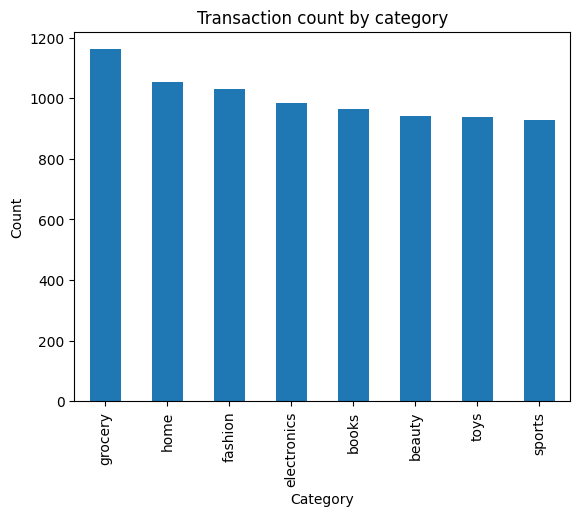

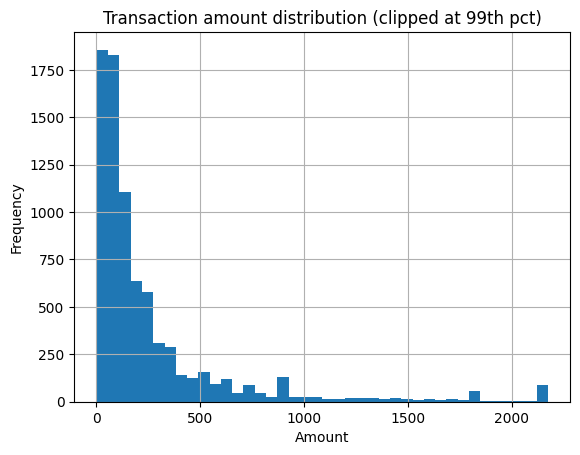

In [5]:
print("Customers:", customers.shape)
print("Products:", products.shape)
print("Transactions:", transactions.shape)

# Category distribution
cat_counts = transactions["category"].value_counts().sort_values(ascending=False)
display(cat_counts)

plt.figure()
cat_counts.plot(kind="bar")
plt.title("Transaction count by category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

# Spend distribution
plt.figure()
transactions["amount"].clip(upper=transactions["amount"].quantile(0.99)).hist(bins=40)
plt.title("Transaction amount distribution (clipped at 99th pct)")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()


## 3) Feature engineering (RFM + behavior)

In [6]:
# RFM features at customer level
snapshot_date = transactions["txn_time"].max() + pd.Timedelta(days=1)

rfm = (transactions
       .groupby("customer_id")
       .agg(
           recency_days=("txn_time", lambda x: (snapshot_date - x.max()).days),
           frequency=("txn_id", "count"),
           monetary=("amount", "sum"),
           avg_basket=("amount", "mean"),
           avg_qty=("qty", "mean"),
       )
       .reset_index())

# Category shares per customer
cat_pivot = (transactions
             .pivot_table(index="customer_id", columns="category", values="amount", aggfunc="sum", fill_value=0.0))
cat_share = cat_pivot.div(cat_pivot.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0)
cat_share.columns = [f"share_{c}" for c in cat_share.columns]

features = (customers
            .merge(rfm, on="customer_id", how="left")
            .merge(cat_share.reset_index(), on="customer_id", how="left"))

features = features.fillna(0)
features.head()


,customer_id,age,gender,income_band,region,recency_days,frequency,monetary,avg_basket,avg_qty,share_beauty,share_books,share_electronics,share_fashion,share_grocery,share_home,share_sports,share_toys
0,1,22,M,low,west,7,11,1956.895950,177.899632,1.909091,0.039935,0.015308,0.240359,0.252032,0.044370,0.280242,0.127753,0.000000
1,2,58,M,low,west,31,20,7336.289453,366.814473,2.250000,0.058803,0.024195,0.782660,0.032714,0.022560,0.000000,0.042344,0.036724
2,3,52,F,low,west,2,20,5440.179021,272.008951,2.150000,0.027390,0.024779,0.445028,0.118206,0.043721,0.107228,0.206204,0.027444
3,4,40,F,mid,south,6,15,3687.004176,245.800278,2.066667,0.040087,0.072211,0.291547,0.053110,0.020592,0.219141,0.215789,0.087522
4,5,40,F,mid,west,10,18,4229.738970,234.985498,1.777778,0.033509,0.019830,0.540550,0.028581,0.006448,0.223440,0.096492,0.051150


## 4) Customer segmentation with K-Means

In [7]:
# Select numeric columns for clustering (exclude IDs)
num_cols = ["age","recency_days","frequency","monetary","avg_basket","avg_qty"] + [c for c in features.columns if c.startswith("share_")]
X_cluster = features[num_cols].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Choose k (simple fixed k; feel free to tune)
K = 5
kmeans = KMeans(n_clusters=K, n_init=10, random_state=RANDOM_SEED)
features["segment"] = kmeans.fit_predict(X_scaled)

features["segment"].value_counts().sort_index()


segment
0    186
1     65
2    123
3     31
4     95
Name: count, dtype: int64

## 5) Next purchase category prediction (Random Forest)

In [8]:
# Build a supervised dataset:
# For each customer, take their last transaction category as the label,
# and use features computed at snapshot_date (works for demo).

last_tx = (transactions.sort_values("txn_time")
           .groupby("customer_id")
           .tail(1)[["customer_id","category","txn_time"]]
           .rename(columns={"category":"label_next_category","txn_time":"last_tx_time"}))

data = features.merge(last_tx, on="customer_id", how="inner")

# Encode categoricals
model_df = data.copy()
model_df = pd.get_dummies(model_df, columns=["gender","income_band","region"], drop_first=True)

y = model_df["label_next_category"]
X = model_df.drop(columns=["label_next_category","last_tx_time"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_SEED, stratify=y
)

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=RANDOM_SEED,
    class_weight="balanced_subsample",
    n_jobs=-1
)
rf.fit(X_train, y_train)

pred = rf.predict(X_test)
print(classification_report(y_test, pred))


              precision    recall  f1-score   support

      beauty       0.17      0.25      0.20        16
       books       0.14      0.08      0.10        13
 electronics       0.23      0.39      0.29        18
     fashion       0.06      0.06      0.06        16
     grocery       0.30      0.19      0.23        16
        home       0.21      0.20      0.21        15
      sports       0.15      0.12      0.13        17
        toys       0.00      0.00      0.00        14

    accuracy                           0.17       125
   macro avg       0.16      0.16      0.15       125
weighted avg       0.16      0.17      0.16       125



## 6) Top-k recommendations with probabilities + export CSV

In [12]:
from pathlib import Path

def top_k_recommendations(model, X_input, k=3):
    proba = model.predict_proba(X_input)
    classes = model.classes_
    top_idx = np.argsort(proba, axis=1)[:, ::-1][:, :k]
    top_classes = classes[top_idx]
    top_scores = np.take_along_axis(proba, top_idx, axis=1)
    return top_classes, top_scores

# Generate recommendations for all customers in data
X_all = X
top_k = 3
top_cats, top_scores = top_k_recommendations(rf, X_all, k=top_k)

out = pd.DataFrame({
    "customer_id": model_df["customer_id"].values,
    "segment": data["segment"].values,
    "actual_last_category": data["label_next_category"].values,
})

for i in range(top_k):
    out[f"rec_{i+1}_category"] = top_cats[:, i]
    out[f"rec_{i+1}_score"] = np.round(top_scores[:, i], 4)

# Save
outputs_dir = Path("outputs")
outputs_dir.mkdir(parents=True, exist_ok=True)
csv_path = outputs_dir / "predictions.csv"
out.to_csv(csv_path, index=False)

out.head(10), str(csv_path)


(   customer_id  segment actual_last_category rec_1_category  rec_1_score  \
 0            1        4              fashion        fashion       0.7133   
 1            2        2          electronics         sports       0.2067   
 2            3        0               sports        fashion       0.2133   
 3            4        4                 home           home       0.6500   
 4            5        0               sports         beauty       0.2067   
 5            6        0                 home           home       0.7100   
 6            7        0                 toys           toys       0.6733   
 7            8        2              grocery    electronics       0.2033   
 8            9        0              fashion         beauty       0.2400   
 9           10        2          electronics    electronics       0.7133   
 
   rec_2_category  rec_2_score rec_3_category  rec_3_score  
 0         beauty       0.0733           home       0.0467  
 1          books       0.176

## 7) Example: recommendations for a specific customer

In [10]:
def recommend_for_customer(customer_id: int, k=2):
    row_idx = np.where(model_df["customer_id"].values == customer_id)[0]
    if len(row_idx) == 0:
        raise ValueError("customer_id not found in modeling dataset")
    i = int(row_idx[0])
    recs = [(out.loc[i, f"rec_{j}_category"], float(out.loc[i, f"rec_{j}_score"])) for j in range(1, k+1)]
    return recs

customer_id = 10
print("Customer", customer_id, "segment:", int(out.loc[out.customer_id==customer_id, "segment"].iloc[0]))
print("Top-2 recommendations:", recommend_for_customer(customer_id, k=2))


Customer 10 segment: 2
Top-2 recommendations: [(np.str_('electronics'), 0.7133), (np.str_('grocery'), 0.0633)]
